# Capstone Project - The Battle of Neighborhoods

## Background

## Data

In [116]:
import numpy as np 

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [117]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
import folium 
from geopy.geocoders import Nominatim 

In [118]:
List_url='https://en.wikipedia.org/wiki/List_of_cities_in_Ohio'
source = requests.get(List_url).text
soup = BeautifulSoup(source, 'xml')
table=soup.find('table')
column_names=['City','Population','County']
df = pd.DataFrame(columns=column_names)
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data
        df.head()

In [120]:
df.head()

,City,Population,County
0,Akron,"198,006",Summit
1,Alliance,"21,616",Mahoning
2,Amherst,"12,021",Lorain
3,Ashland,"20,423",Ashland
4,Ashtabula,"18,079",Ashtabula


In [35]:
df.head()

,City,Population,County
0,Akron,"198,006",Summit
1,Alliance,"21,616",Mahoning
2,Amherst,"12,021",Lorain
3,Ashland,"20,423",Ashland
4,Ashtabula,"18,079",Ashtabula


In [36]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [121]:
# read data from github with location info for all the cities in OH, (geo_df)
geo_df=pd.read_csv('https://raw.githubusercontent.com/yywang118/Coursera-Capstone/master/OHIO_location.csv')

In [122]:
geo_df.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,NaN,39.969238,-82.936864,Bexley,OH,Ohio,True,NaN,2810,34.9,39089,Franklin,NaN,NaN,NaN,NaN,NaN,NaN
1,43001.0,40.088650,-82.613630,Alexandria,OH,Ohio,True,NaN,2810,34.9,39089,Licking,{'39089':100},Licking,39089,False,False,America/New_York
2,43002.0,40.063330,-83.173900,Amlin,OH,Ohio,True,NaN,3744,872.4,39049,Franklin,{'39049':100},Franklin,39049,False,False,America/New_York
3,43003.0,40.410340,-82.975380,Ashley,OH,Ohio,True,NaN,3005,33.2,39041,Delaware,"{'39041':74.7,'39117':25.3}",Delaware|Morrow,39041|39117,False,False,America/New_York
4,43004.0,40.015810,-82.800120,Blacklick,OH,Ohio,True,NaN,26139,678.2,39049,Franklin,{'39049':100},Franklin,39049,False,False,America/New_York


In [39]:
geo_df_loc=geo_df[['zip','lat','lng','city','county_name']]

In [40]:
geo_df_loc.head()

,zip,lat,lng,city,county_name
0,NaN,39.969238,-82.936864,Bexley,Franklin
1,43001.0,40.088650,-82.613630,Alexandria,Licking
2,43002.0,40.063330,-83.173900,Amlin,Franklin
3,43003.0,40.410340,-82.975380,Ashley,Delaware
4,43004.0,40.015810,-82.800120,Blacklick,Franklin


In [124]:
## merge the two dataset
geo_df_loc.rename(columns={'county_name':'County'},inplace=True)
geo_df_loc.rename(columns={'city':'City'},inplace=True)
##geo_merged = pd.merge(df,geo_df_loc, on='City')
##geo_merged.head()
##geo_concat=pd.concat([df, geo_df_loc.reindex(df['City'])], axis=1)

#pd.merge_asof(df, geo_df_loc, on='City',by='County')
#geo_merged=pd.merge(df, geo_df_loc, on='City',  how='left')
geo_merged = df.merge(geo_df_loc, on="City", how = 'inner')

In [125]:
geo_merged.head()

,City,Population,County_x,zip,lat,lng,County_y
0,Akron,"198,006",Summit,44301.0,41.04386,-81.52450,Summit
1,Akron,"198,006",Summit,44302.0,41.08955,-81.53883,Summit
2,Akron,"198,006",Summit,44303.0,41.10467,-81.53686,Summit
3,Akron,"198,006",Summit,44304.0,41.08306,-81.50782,Summit
4,Akron,"198,006",Summit,44305.0,41.07587,-81.46140,Summit


In [126]:
geo_merged.drop_duplicates(subset ="City", 
                     keep = "first", inplace = True) 

In [127]:
geo_merged.head()

,City,Population,County_x,zip,lat,lng,County_y
0,Akron,"198,006",Summit,44301.0,41.04386,-81.52450,Summit
17,Alliance,"21,616",Mahoning,44601.0,40.91935,-81.13021,Stark
18,Amherst,"12,021",Lorain,44001.0,41.36494,-82.26177,Lorain
19,Ashland,"20,423",Ashland,44805.0,40.87292,-82.31686,Ashland
20,Ashtabula,"18,079",Ashtabula,44004.0,41.85339,-80.78858,Ashtabula


In [45]:
geo_final_data=geo_merged[['City','Population','County_y','zip','lat','lng']]


In [184]:
franklin_data=geo_final_data[geo_final_data['County_y'].str.contains("Franklin",na=False)]
franklin_data

,City,Population,County_y,zip,lat,lng
34,Bexley,"13,057",Franklin,NaN,39.969238,-82.936864
46,Canal Winchester,"7,101",Franklin,43110.0,39.826340,-82.799450
141,Columbus,"892,672",Franklin,43085.0,40.099860,-83.015700
207,Dublin,"48,647",Franklin,43016.0,40.098590,-83.153760
228,Grove City,"41,627",Franklin,43123.0,39.868550,-83.119880
229,Groveport,"5,363",Franklin,43125.0,39.836640,-82.884460
235,Hilliard,"33,672",Franklin,43026.0,40.022750,-83.185520
289,New Albany,"7,724",Franklin,43054.0,40.080840,-82.803480
315,Reynoldsburg,"35,893",Franklin,43068.0,39.956370,-82.785020
379,Westerville,"36,120",Franklin,43081.0,40.110640,-82.891340


In [149]:
franklin_data

,City,Population,County_y,zip,lat,lng
34,Bexley,"13,057",Franklin,NaN,39.969238,-82.936864
46,Canal Winchester,"7,101",Franklin,43110.0,39.826340,-82.799450
141,Columbus,"892,672",Franklin,43085.0,40.099860,-83.015700
207,Dublin,"48,647",Franklin,43016.0,40.098590,-83.153760
228,Grove City,"41,627",Franklin,43123.0,39.868550,-83.119880
229,Groveport,"5,363",Franklin,43125.0,39.836640,-82.884460
235,Hilliard,"33,672",Franklin,43026.0,40.022750,-83.185520
289,New Albany,"7,724",Franklin,43054.0,40.080840,-82.803480
315,Reynoldsburg,"35,893",Franklin,43068.0,39.956370,-82.785020
379,Westerville,"36,120",Franklin,43081.0,40.110640,-82.891340


In [185]:
franklin_data = franklin_data[franklin_data.City != 'Groveport']
franklin_data = franklin_data[franklin_data.City != 'New Albany']
franklin_data = franklin_data[franklin_data.City != 'Canal Winchester']

In [186]:
final_data=franklin_data
final_data

,City,Population,County_y,zip,lat,lng
34,Bexley,"13,057",Franklin,NaN,39.969238,-82.936864
141,Columbus,"892,672",Franklin,43085.0,40.099860,-83.015700
207,Dublin,"48,647",Franklin,43016.0,40.098590,-83.153760
228,Grove City,"41,627",Franklin,43123.0,39.868550,-83.119880
235,Hilliard,"33,672",Franklin,43026.0,40.022750,-83.185520
315,Reynoldsburg,"35,893",Franklin,43068.0,39.956370,-82.785020
379,Westerville,"36,120",Franklin,43081.0,40.110640,-82.891340


In [187]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '4VD0V2405OACGG0WALX5JWAXVM3BXYIUU1UUP3H1CGG31ODJ' # your Foursquare ID
    CLIENT_SECRET = 'FMN2SIOZGDHRYCEH3UWO4HXCDYT0YUPRPN24FOLJIAIAVDS0' # your Foursquare Secret
    VERSION = '20200212'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [188]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '4VD0V2405OACGG0WALX5JWAXVM3BXYIUU1UUP3H1CGG31ODJ' # your Foursquare ID
    CLIENT_SECRET = 'FMN2SIOZGDHRYCEH3UWO4HXCDYT0YUPRPN24FOLJIAIAVDS0' # your Foursquare Secret
    VERSION = '20200212'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [189]:
def getNearbyVenues(names, latitudes, longitudes):
    CLIENT_ID = '4VD0V2405OACGG0WALX5JWAXVM3BXYIUU1UUP3H1CGG31ODJ' # your Foursquare ID
    CLIENT_SECRET = 'FMN2SIOZGDHRYCEH3UWO4HXCDYT0YUPRPN24FOLJIAIAVDS0' # your Foursquare Secret
    VERSION = '20200212'
    radius=15000
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [190]:
franklin_venues = getNearbyVenues(names=franklin_data['City'],
                                   latitudes=franklin_data['lat'],
                                   longitudes=franklin_data['lng']
                                  )

Bexley
Columbus
Dublin
Grove City
Hilliard
Reynoldsburg
Westerville


In [191]:
franklin_venues.shape

(700, 7)

In [192]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

franklin_venues_only_restaurant = franklin_venues[franklin_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
franklin_venues_only_restaurant.index = np.arange(1, len(franklin_venues_only_restaurant)+1)
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", franklin_venues_only_restaurant.shape)
franklin_venues_only_restaurant

Shape of the Data-Frame with Venue Category only Restaurant:  (172, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Bexley,39.969238,-82.936864,Giuseppe's Ritrovo,39.957316,-82.938282,Italian Restaurant
2,Bexley,39.969238,-82.936864,Brassica,39.957333,-82.940051,Mediterranean Restaurant
3,Bexley,39.969238,-82.936864,Tavern Olde Towne,39.962913,-82.976560,Restaurant
4,Bexley,39.969238,-82.936864,Schmidt's Restaurant und Sausage Haus,39.946222,-82.990993,German Restaurant
5,Bexley,39.969238,-82.936864,Brassica,39.976273,-83.003219,Restaurant
6,Bexley,39.969238,-82.936864,Lindey's,39.950775,-82.993778,American Restaurant
7,Bexley,39.969238,-82.936864,Arepazo Tapas Bar Grill,39.951473,-82.998798,Latin American Restaurant
8,Bexley,39.969238,-82.936864,The Guild House,39.975110,-83.002959,American Restaurant
9,Bexley,39.969238,-82.936864,Club 185,39.952528,-82.993522,American Restaurant
10,Bexley,39.969238,-82.936864,Marcella's,39.974913,-83.003256,Italian Restaurant


In [193]:
#franklin_venues.groupby('Neighborhood').count()
#franklin_venues_only_restaurant.groupby('Neighborhood').count()
print (franklin_venues_only_restaurant['Venue Category'].value_counts())

American Restaurant              36
Mexican Restaurant               25
Italian Restaurant               12
Greek Restaurant                 11
Fast Food Restaurant             11
Mediterranean Restaurant          8
Asian Restaurant                  8
Japanese Restaurant               7
Chinese Restaurant                6
Sushi Restaurant                  6
Seafood Restaurant                4
German Restaurant                 4
French Restaurant                 4
Restaurant                        3
Thai Restaurant                   3
Latin American Restaurant         3
Indian Restaurant                 3
Vietnamese Restaurant             3
Ramen Restaurant                  2
New American Restaurant           2
Vegetarian / Vegan Restaurant     2
Fondue Restaurant                 1
Modern European Restaurant        1
Brazilian Restaurant              1
Hotpot Restaurant                 1
Ethiopian Restaurant              1
Cajun / Creole Restaurant         1
Middle Eastern Restaurant   

In [194]:

# create a dataframe of top 10 categories
franklin_venues_only_restaurant_Top10 = franklin_venues_only_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
franklin_venues_only_restaurant_Top10=franklin_venues_only_restaurant_Top10.reset_index()
#Franklin_5_Dist_Venues_Top10

franklin_venues_only_restaurant_Top10.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
franklin_venues_only_restaurant_Top10

,Venue Category,Frequency
0,American Restaurant,36
1,Mexican Restaurant,25
2,Italian Restaurant,12
3,Greek Restaurant,11
4,Fast Food Restaurant,11
5,Mediterranean Restaurant,8
6,Asian Restaurant,8
7,Japanese Restaurant,7
8,Chinese Restaurant,6
9,Sushi Restaurant,6


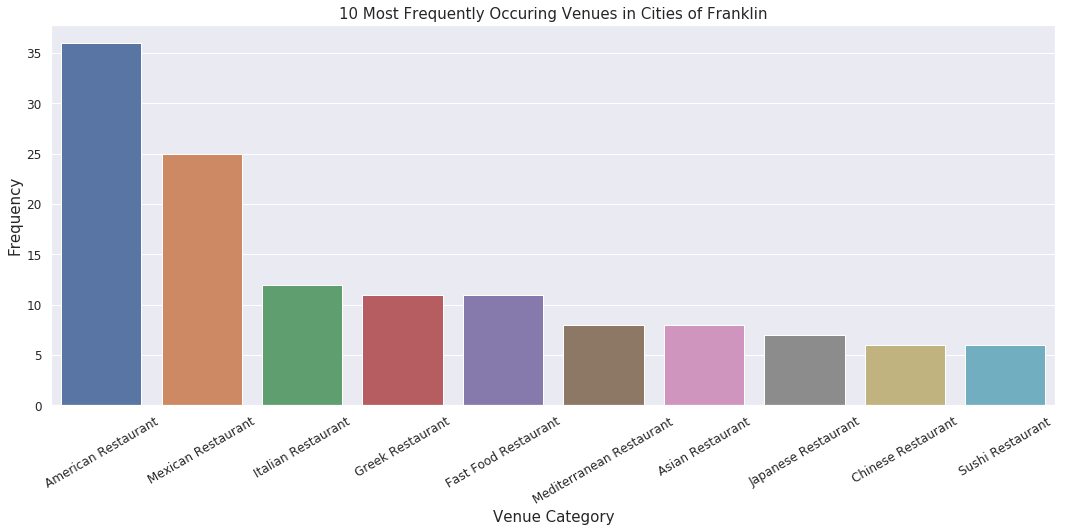

In [195]:
import seaborn as sns
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Frequency", data=franklin_venues_only_restaurant_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in Cities of Franklin', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

In [172]:
franklin_onehot.head()

,Neighborhood,American Restaurant,Arepa Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Chinese Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Fondue Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,Bexley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bexley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bexley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Bexley,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Bexley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [196]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [197]:
franklin_grouped = franklin_onehot.groupby('Neighborhood').mean().reset_index()
franklin_grouped

,Neighborhood,American Restaurant,Arepa Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Chinese Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Fondue Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Bexley,0.277778,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.055556,0.055556,0.055556,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556
1,Canal Winchester,0.294118,0.000000,0.117647,0.00,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.117647,0.000000,0.058824,0.000000,0.000000,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.058824,0.000000,0.000000,0.000000
2,Columbus,0.230769,0.000000,0.076923,0.00,0.000000,0.000000,0.000000,0.038462,0.000000,0.076923,0.000000,0.115385,0.000000,0.038462,0.038462,0.076923,0.000000,0.000000,0.038462,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.038462,0.000000,0.038462,0.000000,0.076923,0.000000
3,Dublin,0.185185,0.000000,0.074074,0.00,0.000000,0.037037,0.000000,0.111111,0.000000,0.037037,0.000000,0.074074,0.000000,0.037037,0.111111,0.037037,0.000000,0.000000,0.037037,0.148148,0.000000,0.037037,0.000000,0.037037,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000
4,Grove City,0.250000,0.000000,0.000000,0.00,0.000000,0.050000,0.000000,0.100000,0.000000,0.000000,0.100000,0.050000,0.000000,0.000000,0.000000,0.100000,0.000000,0.100000,0.050000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Groveport,0.238095,0.000000,0.047619,0.00,0.000000,0.000000,0.047619,0.142857,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.095238,0.000000,0.000000,0.000000,0.047619,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.047619,0.095238,0.047619,0.000000,0.047619
6,Hilliard,0.214286,0.000000,0.071429,0.00,0.035714,0.035714,0.000000,0.035714,0.000000,0.035714,0.000000,0.071429,0.000000,0.035714,0.107143,0.071429,0.000000,0.000000,0.035714,0.178571,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000
7,New Albany,0.206897,0.034483,0.068966,0.00,0.000000,0.034483,0.000000,0.068966,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.068966,0.000000,0.000000,0.000000,0.103448,0.172414,0.000000,0.000000,0.000000,0.000000,0.068966,0.034483,0.103448,0.000000,0.000000,0.000000,0.000000,0.000000
8,Reynoldsburg,0.178571,0.035714,0.035714,0.00,0.000000,0.035714,0.035714,0.107143,0.000000,0.000000,0.000000,0.071429,0.035714,0.000000,0.035714,0.000000,0.035714,0.000000,0.035714,0.178571,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.035714,0.000000,0.000000,0.035714
9,Westerville,0.160000,0.000000,0.040000,0.04,0.000000,0.080000,0.000000,0.040000,0.040000,0.000000,0.000000,0.040000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.080000,0.200000,0.000000,0.000000,0.000000,0.000000,0.040000,0.080000,0.040000,0.000000,0.040000,0.000000,0.000000,0.040000


In [206]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = franklin_grouped['Neighborhood']

for ind in np.arange(franklin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(franklin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bexley,American Restaurant,Italian Restaurant,New American Restaurant,German Restaurant,Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Vietnamese Restaurant,Ramen Restaurant
1,Canal Winchester,American Restaurant,Fast Food Restaurant,Italian Restaurant,Asian Restaurant,Korean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Greek Restaurant,Sushi Restaurant,Thai Restaurant
2,Columbus,American Restaurant,Greek Restaurant,Mexican Restaurant,Asian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Thai Restaurant,Seafood Restaurant,Mediterranean Restaurant
3,Dublin,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Italian Restaurant,Asian Restaurant,Greek Restaurant,Chinese Restaurant,French Restaurant,Indian Restaurant,Mediterranean Restaurant
4,Grove City,American Restaurant,Mexican Restaurant,Fast Food Restaurant,German Restaurant,Latin American Restaurant,Japanese Restaurant,Seafood Restaurant,Greek Restaurant,Chinese Restaurant,Mediterranean Restaurant
5,Groveport,American Restaurant,Fast Food Restaurant,Thai Restaurant,Italian Restaurant,Middle Eastern Restaurant,Asian Restaurant,Ethiopian Restaurant,Greek Restaurant,Mediterranean Restaurant,Vietnamese Restaurant
6,Hilliard,American Restaurant,Mexican Restaurant,Italian Restaurant,Asian Restaurant,Greek Restaurant,Japanese Restaurant,Ramen Restaurant,Sushi Restaurant,Mediterranean Restaurant,Cajun / Creole Restaurant
7,New Albany,American Restaurant,Mexican Restaurant,Sushi Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Italian Restaurant,Asian Restaurant,Restaurant,Fondue Restaurant,Chinese Restaurant
8,Reynoldsburg,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Sushi Restaurant,Greek Restaurant,Mediterranean Restaurant,Arepa Restaurant,Asian Restaurant,Chinese Restaurant,Ethiopian Restaurant
9,Westerville,Mexican Restaurant,American Restaurant,Chinese Restaurant,Seafood Restaurant,Mediterranean Restaurant,Asian Restaurant,Brazilian Restaurant,Fast Food Restaurant,Fondue Restaurant,Greek Restaurant


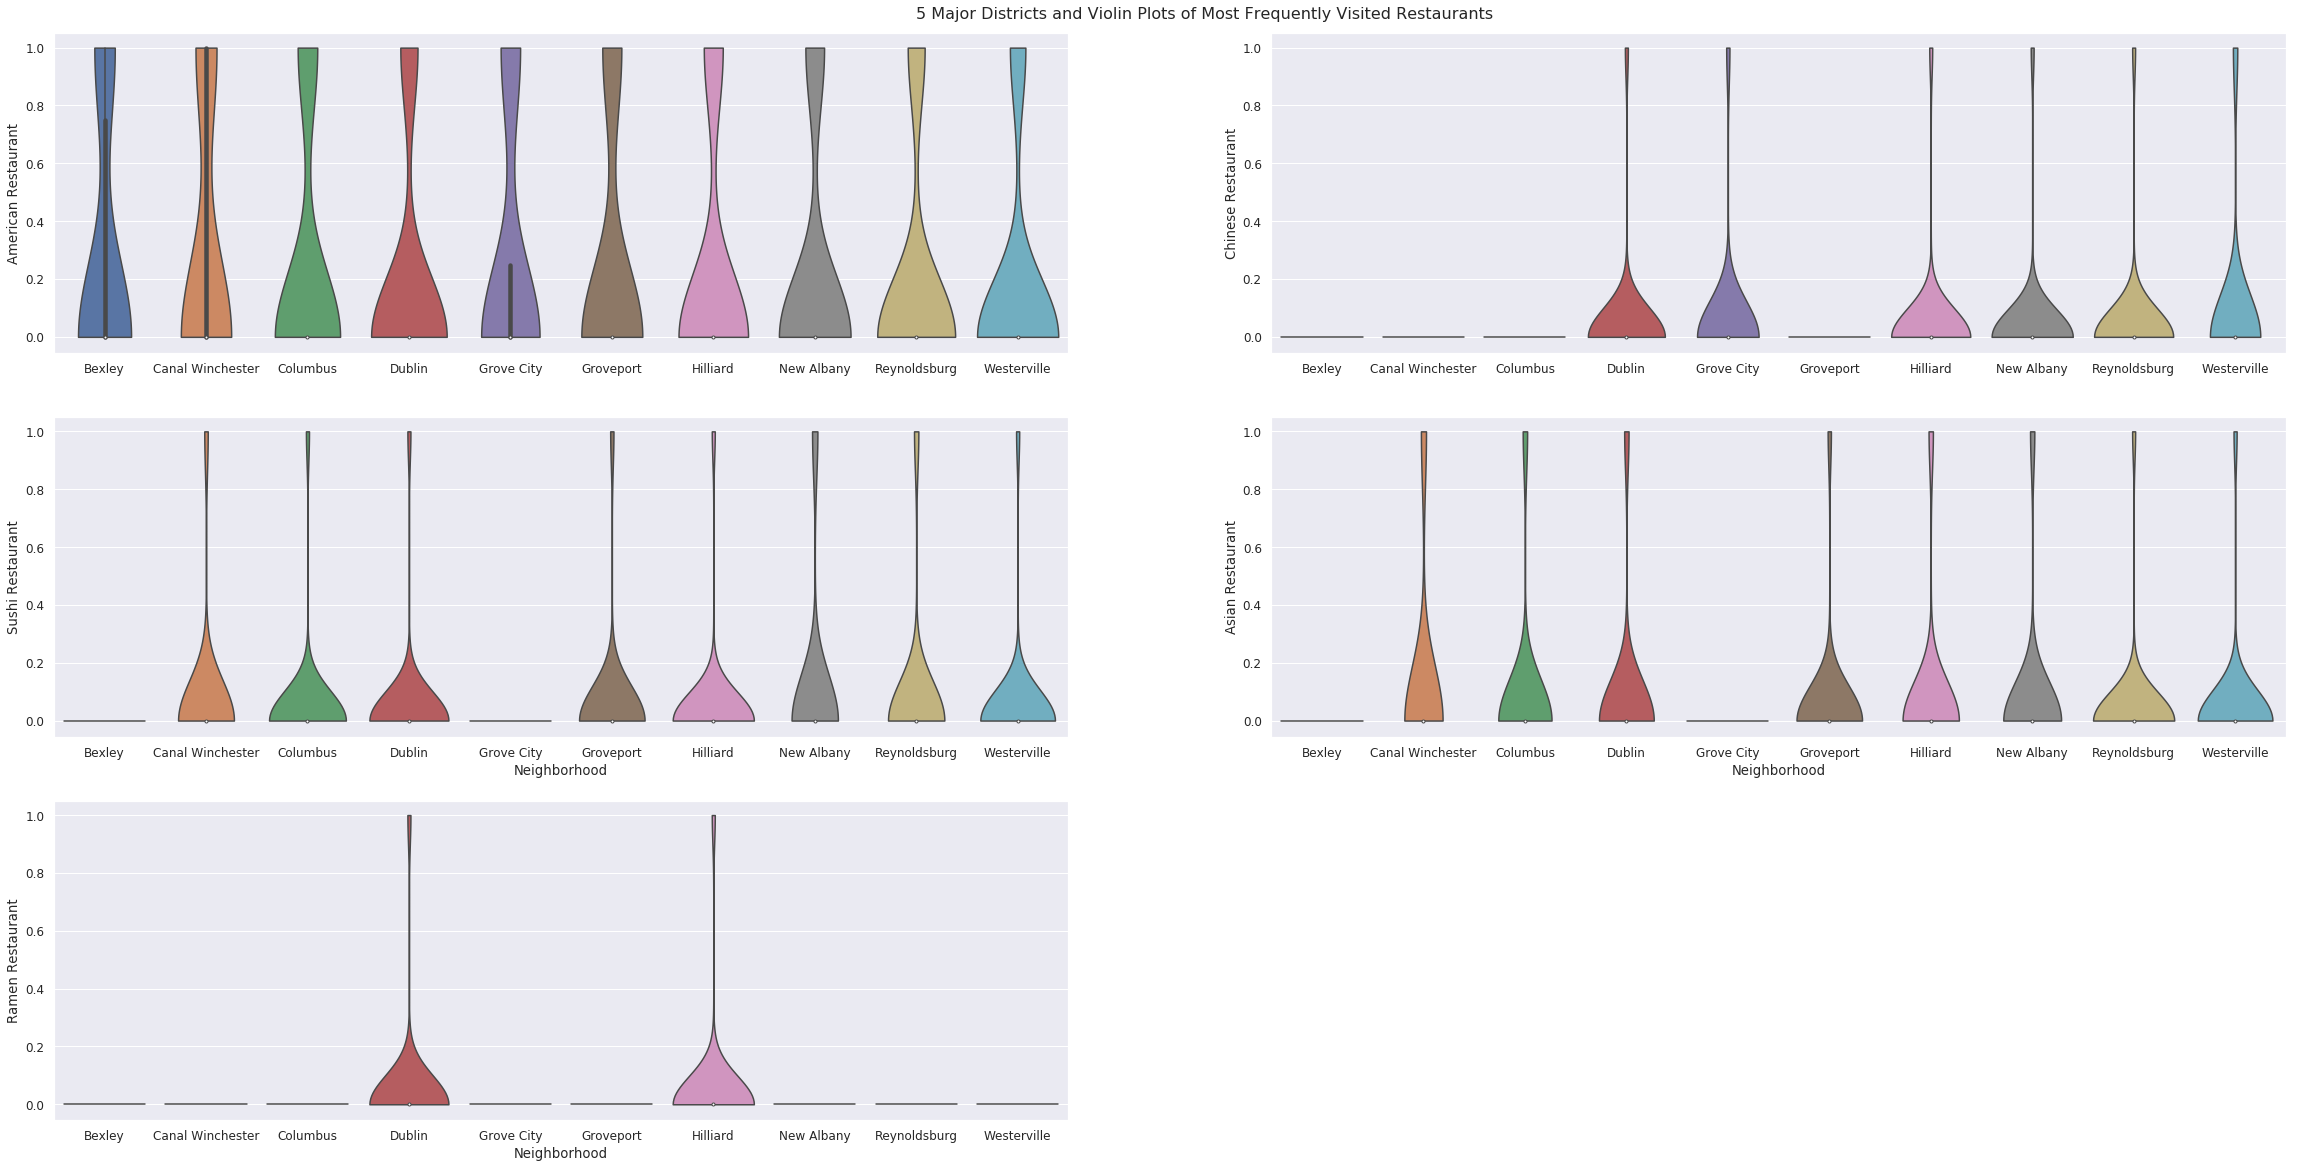

In [207]:
# Let's try Categorical plot 


fig = plt.figure(figsize=(40,20))

sns.set(font_scale=1.1)
ax = plt.subplot(3,2,1)
sns.violinplot(x="Neighborhood", y="American Restaurant", data=franklin_onehot, cut=0);
plt.xlabel("")
ax = plt.subplot(3,2,2)
sns.violinplot(x="Neighborhood", y="Chinese Restaurant", data=franklin_onehot, cut=0);
plt.xlabel("")
plt.subplot(3,2,3)
sns.violinplot(x="Neighborhood", y="Sushi Restaurant", data=franklin_onehot, cut=0);
plt.subplot(3,2,4)
sns.violinplot(x="Neighborhood", y="Asian Restaurant", data=franklin_onehot, cut=0);
plt.subplot(3,2,5)
sns.violinplot(x="Neighborhood", y="Ramen Restaurant", data=franklin_onehot, cut=0);
#ax.title.set_text("5 Major Districts  Violin Plots of Most Frequently Visited Restaurants")
ax.text(-4.0, 1.1, '5 Major Districts and Violin Plots of Most Frequently Visited Restaurants', fontsize=16)
plt.savefig ("Violin_plots_Dist_Frequent_Restaurant.png", dpi=240)
plt.show()

[18, 26, 27, 20, 28, 28, 25]


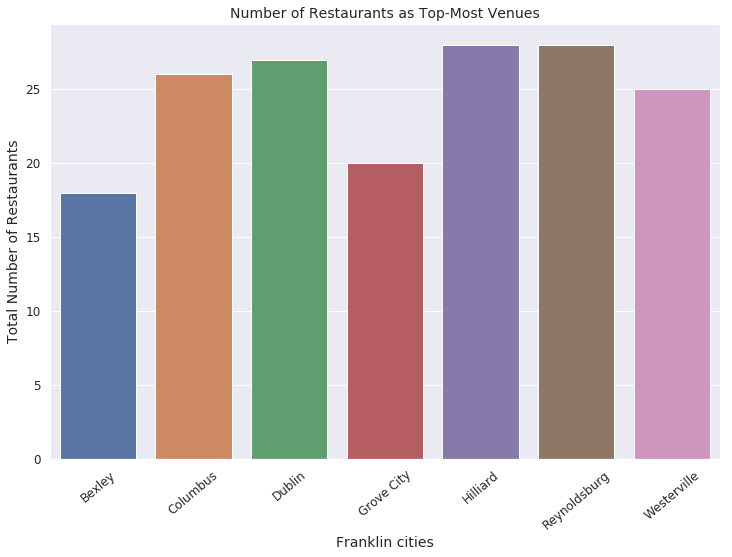

In [201]:
#try groupby to play with restaurant 

franklin_venues_only_restaurant = franklin_venues.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
franklin_venues_only_restaurant_df = franklin_venues_only_restaurant.to_frame().reset_index()
franklin_venues_only_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']

franklin_venues_only_restaurant_df.index = np.arange(1, len(franklin_venues_only_restaurant_df)+1)


list_rest_no = franklin_venues_only_restaurant_df['Number of Restaurant'].to_list()
print (list_rest_no)
fig = plt.figure(figsize=(12,8))
bar = sns.barplot(x='Neighborhood', y='Number of Restaurant', data=franklin_venues_only_restaurant_df)

bar.set_ylabel("Total Number of Restaurants", fontsize=14)
bar.set_xlabel("Franklin cities", fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(),rotation=40)
bar.set_title("Number of Restaurants as Top-Most Venues", fontsize=14)
#plt.savefig("No_of_Rest_as_Top_Venues.png", dpi=240)
plt.show()

In [202]:
kclusters = 5

franklin_grouped_clustering = franklin_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(franklin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 4, 4, 2, 0, 4, 1, 1, 1], dtype=int32)

In [203]:
# add clustering labels
neighborhoods_venues_sorted.rename(columns={'Neighborhood':'City'},inplace=True)



In [204]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

franklin_merged = franklin_data

 to add latitude/longitude for each neighborhood
franklin_merged = franklin_merged.join(neighborhoods_venues_sorted.set_index('City'), on='City')

franklin_merged.head()

,City,Population,County_y,zip,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Bexley,"13,057",Franklin,NaN,39.969238,-82.936864,3,American Restaurant,Italian Restaurant,New American Restaurant,German Restaurant,Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Vietnamese Restaurant,Ramen Restaurant
141,Columbus,"892,672",Franklin,43085.0,40.099860,-83.015700,4,American Restaurant,Greek Restaurant,Mexican Restaurant,Asian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Thai Restaurant,Seafood Restaurant,Mediterranean Restaurant
207,Dublin,"48,647",Franklin,43016.0,40.098590,-83.153760,4,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Italian Restaurant,Asian Restaurant,Greek Restaurant,Chinese Restaurant,French Restaurant,Indian Restaurant,Mediterranean Restaurant
228,Grove City,"41,627",Franklin,43123.0,39.868550,-83.119880,2,American Restaurant,Mexican Restaurant,Fast Food Restaurant,German Restaurant,Latin American Restaurant,Japanese Restaurant,Seafood Restaurant,Greek Restaurant,Chinese Restaurant,Mediterranean Restaurant
235,Hilliard,"33,672",Franklin,43026.0,40.022750,-83.185520,4,American Restaurant,Mexican Restaurant,Italian Restaurant,Asian Restaurant,Greek Restaurant,Japanese Restaurant,Ramen Restaurant,Sushi Restaurant,Mediterranean Restaurant,Cajun / Creole Restaurant


In [205]:
address = 'Columbus, OH'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Ohio are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Ohio are 39.9622601, -83.0007065.


In [65]:

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(franklin_merged['lat'], franklin_merged['lng'], franklin_merged['City'], franklin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters